In [1]:
from utils import *
from build_model import *

'''
Dataset: Particles
Dataset: Particles_Classes
Dataset: Particles_Names

array([b'MET_class_1', b'Four_Ele_class_2', b'Four_Mu_class_3',
       b'Ten_Jet_class_4'], dtype='|S16')
       
array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')

shape = (n, 19, 4)
'''

files = ['background_for_training.h5',
         'Ato4l_lepFilter_13TeV_filtered.h5',
         'hChToTauNu_13TeV_PU20_filtered.h5',
         'hToTauTau_13TeV_PU20_filtered.h5',
         'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

data = []
for i in range(len(files)):
    with h5py.File(files[i], 'r') as hdf:
        if i == 0:
            data.append(hdf['Particles'][:200000])
        else:
            data.append(hdf['Particles'][:])
    print(data[i].shape)

data[1][2]

(200000, 19, 4)
(55969, 19, 4)
(760272, 19, 4)
(691283, 19, 4)
(340544, 19, 4)


array([[ 6.76132965,  0.        ,  1.15189862,  1.        ],
       [28.02878571,  0.0848856 , -1.33467388,  2.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 7.86102533,  0.0485602 ,  1.2370621 ,  3.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [41.65947342,  0.95587289, -2.99767089,  4.        ],
       [29.83676529,  0.91927922,  0.05157597,  4.        ],
       [28.80836487,  0.09456544, -1.33484852,  4.        ],
       [24.68841934, -1.10409391, -2.82231712,  4.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

In [ ]:
plot_data(data, 'MET')
plot_data(data, 'Ele')
plot_data(data, 'Mu')
plot_data(data, 'Jet')

## preprocess data

In [2]:
# remove last feature (particle class), which is implicitly assumed in second index ordering
for i in range(len(data)):
    data[i] = np.reshape(data[i][:,:,:3], (data[i].shape[0], -1))

# training data: bkg only
X = data[0]

train_ratio = 0.6
val_ratio = 0.01
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 42)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
del X_train_val

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

for i in range(1, 5):
    data[i] = scaler.transform(data[i])

X_train shape: (120000, 57)
X_val   shape: (2000, 57)
X_test  shape: (78000, 57)


## baseline ae model

In [ ]:
model_ae = build_autoencoder(input_dim=57)
model_ae.summary()

In [ ]:
history = model_ae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=20, batch_size=128)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'train')
axes.plot(history.history['val_loss'], label = 'val')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

score_x_test = compute_mse_for_ae(model_ae, X_test)
score_sig = []
for i in range(4):
    score_sig.append(compute_mse_for_ae(model_ae, data[i+1]))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_x_test, bins=50, alpha=0.5, label='Bkg', density=True)

for i, score_vals in enumerate(score_sig):
    plt.hist(score_vals, bins=50, label=f'{files[i+1]}', density=True, histtype='step')

plt.xlabel('MSE')
#plt.xlim((0,10000))
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_x_test, score_sig[i]])
    labels = np.concatenate([np.zeros_like(score_x_test), np.ones_like(score_sig[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{files[i+1]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

## flow model

Epoch 1/60, Loss: -4.9226
Epoch 2/60, Loss: -9.9198
Epoch 3/60, Loss: -11.1273
Epoch 4/60, Loss: -11.6983
Epoch 5/60, Loss: -11.9037
Epoch 6/60, Loss: -12.3239
Epoch 7/60, Loss: -12.4928
Epoch 8/60, Loss: -11.9368
Epoch 9/60, Loss: -12.5156
Epoch 10/60, Loss: -12.6136
Epoch 11/60, Loss: -12.8001
Epoch 12/60, Loss: -12.1978
Epoch 13/60, Loss: -12.5971
Epoch 14/60, Loss: -12.8131
Epoch 15/60, Loss: -12.8390
Epoch 16/60, Loss: -12.9521
Epoch 17/60, Loss: -11.9636
Epoch 18/60, Loss: -12.6637
Epoch 19/60, Loss: -12.5803
Epoch 20/60, Loss: -12.7009
Epoch 21/60, Loss: -12.8041
Epoch 22/60, Loss: -13.1637
Epoch 23/60, Loss: -12.8557
Epoch 24/60, Loss: -13.2065
Epoch 25/60, Loss: -12.9169
Epoch 26/60, Loss: -13.0634
Epoch 27/60, Loss: -12.5900
Epoch 28/60, Loss: -12.7806
Epoch 29/60, Loss: -12.5696
Epoch 30/60, Loss: -12.7120
Epoch 31/60, Loss: -13.0705
Epoch 32/60, Loss: -11.8575
Epoch 33/60, Loss: -13.3448
Epoch 34/60, Loss: -13.1016
Epoch 35/60, Loss: -13.3171
Epoch 36/60, Loss: -13.2249
Epo

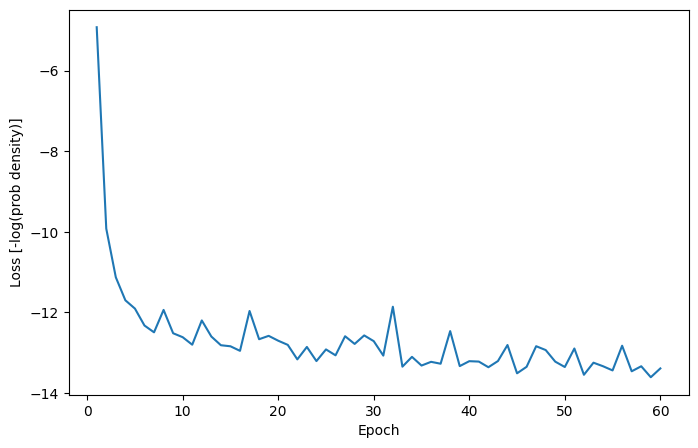

In [3]:
epochs = 60
batch_size = 128

model_nf = NormalizingFlowModel(num_flows=3)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000).batch(batch_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.006)

epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch in train_dataset:
        with tf.GradientTape() as tape:
            loss = nll_loss(model_nf, x_batch)
        grads = tape.gradient(loss, model_nf.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_nf.trainable_variables))
        epoch_loss += loss.numpy()
        num_batches += 1
    avg_loss = epoch_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs+1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss [-log(prob density)]")
plt.show()

nll_x_test = compute_nll_for_nf(model_nf, X_test)

nll_sig = []
for i in range(4):
    nll_sig.append(compute_nll_for_nf(model_nf, data[i+1]))

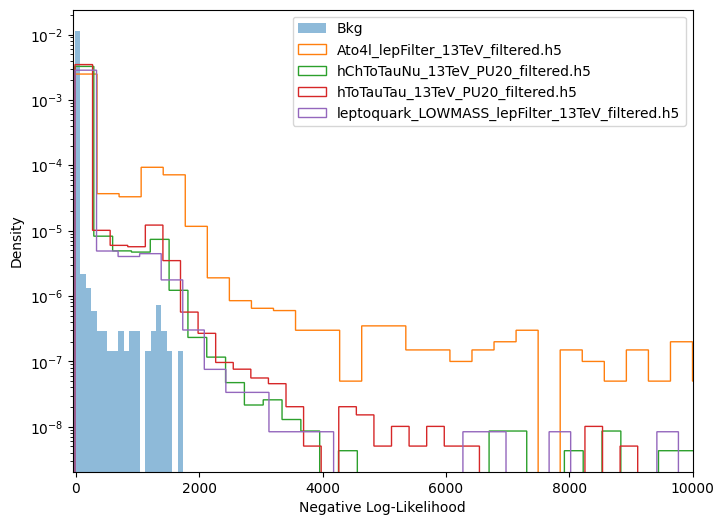

In [7]:
plt.figure(figsize=(8,6))
plt.hist(nll_x_test, bins=20, alpha=0.5, label='Bkg', density=True)

for i, nll_vals in enumerate(nll_sig):
    plt.hist(nll_vals, bins=10000, label=f'{files[i+1]}', density=True, histtype='step')

plt.xlabel('Negative Log-Likelihood')
plt.ylabel('Density')
plt.xlim((-50,10000))
plt.yscale('log')
plt.legend()
plt.show()

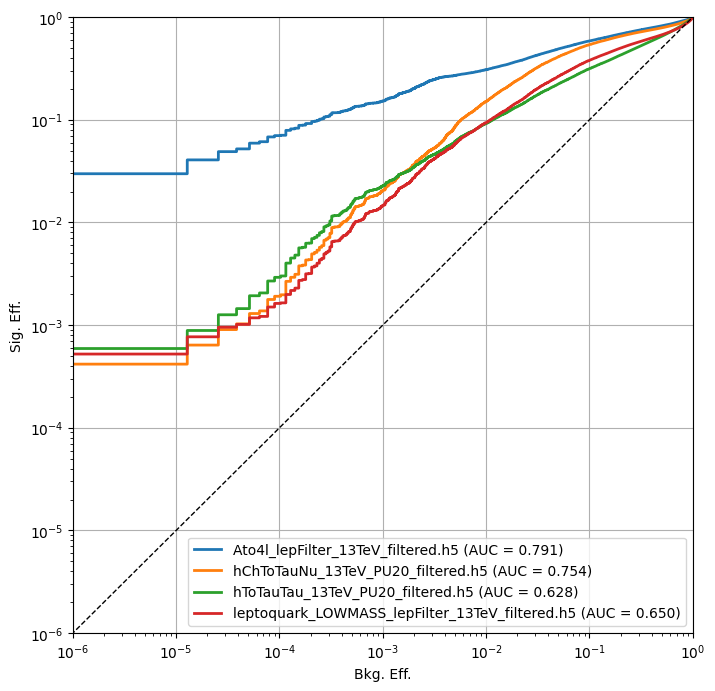

In [8]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([nll_x_test, nll_sig[i]])
    labels = np.concatenate([np.zeros_like(nll_x_test), np.ones_like(nll_sig[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{files[i+1]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

## hls

In [9]:
#print("dense 1 weights:", model_nf.dense1.get_weights())
#print("dense 2 weights:", model_nf.dense2.get_weights())
#print("dense 3 weights:", model_nf.dense3.get_weights())

for i, flow in enumerate(model_nf.flows):
    print(f'--------flow layer {i}--------')
    for weight in flow.weights:
        print(f'{weight.name}: shape = {weight.shape}')
        print(str(weight.numpy()) + '\n')

--------flow layer 0--------
normalizing_flow_model/planar_flow/w:0: shape = (4,)
[-12.59094  -11.641701  11.871289  12.841861]

normalizing_flow_model/planar_flow/u:0: shape = (4,)
[-6.976981  -6.9543624  6.4214606  7.1096206]

normalizing_flow_model/planar_flow/b:0: shape = (1,)
[0.01299851]

--------flow layer 1--------
normalizing_flow_model/planar_flow_1/w:0: shape = (4,)
[ 6.817665  -7.156333   8.390457  -7.8095684]

normalizing_flow_model/planar_flow_1/u:0: shape = (4,)
[ 7.0930486 -7.359327   7.948529  -8.14267  ]

normalizing_flow_model/planar_flow_1/b:0: shape = (1,)
[-0.02948051]

--------flow layer 2--------
normalizing_flow_model/planar_flow_2/w:0: shape = (4,)
[6.584381  6.518894  6.8391137 6.5339704]

normalizing_flow_model/planar_flow_2/u:0: shape = (4,)
[23.484638 24.631702 24.786816 25.242905]

normalizing_flow_model/planar_flow_2/b:0: shape = (1,)
[1.9243195]



In [10]:
input_layer = tf.keras.Input(shape=(57,), name='x_in')
x = model_nf.dense1(input_layer)
x = model_nf.act1(x)
x = model_nf.dense2(x)
x = model_nf.act2(x)
x = model_nf.dense3(x)
x = model_nf.act3(x)
model = tf.keras.Model(inputs=input_layer, outputs=x)

In [11]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model']['Strategy'] = 'Latency'
config['LayerName']['x_in']['Precision'] = 'ap_fixed<12, 4, AP_RND, AP_SAT>'

config

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Interpreting Model
Topology:
Layer name: x_in, layer type: InputLayer, input shapes: [[None, 57]], output shape: [None, 57]
Layer name: dense1, layer type: Dense, input shapes: [[None, 57]], output shape: [None, 32]
Layer name: act1, layer type: LeakyReLU, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: dense2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 16]
Layer name: act2, layer type: LeakyReLU, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense3, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 4]
Layer name: act3, layer type: LeakyReLU, input shapes: [[None, 4]], output shape: [None, 4]


/Users/hofungtsoi/miniforge3/envs/nf/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


{'Model': {'Precision': {'default': 'fixed<16,6>'},
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'x_in': {'Trace': False,
   'Precision': 'ap_fixed<12, 4, AP_RND, AP_SAT>'},
  'dense1': {'Trace': False,
   'Precision': {'result': 'auto', 'weight': 'auto', 'bias': 'auto'}},
  'dense1_linear': {'Trace': False, 'Precision': {'result': 'auto'}},
  'act1': {'Trace': False, 'Precision': {'result': 'auto', 'param': 'auto'}},
  'dense2': {'Trace': False,
   'Precision': {'result': 'auto', 'weight': 'auto', 'bias': 'auto'}},
  'dense2_linear': {'Trace': False, 'Precision': {'result': 'auto'}},
  'act2': {'Trace': False, 'Precision': {'result': 'auto', 'param': 'auto'}},
  'dense3': {'Trace': False,
   'Precision': {'result': 'auto', 'weight': 'auto', 'bias': 'auto'}},
  'dense3_linear': {'Trace': False, 'Precision': {'result': 'auto'}},
  'act3': {'Trace': False, 'Precision': {'result': 'auto', 'param': 'auto'}}}}

In [12]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    project_name='model_test',
    output_dir='model_test',
    part='xcvu13p-flga2577-2-e',
    io_type='io_parallel',
)

hls_model.compile()
hls_model.write()

Interpreting Model
Topology:
Layer name: x_in, layer type: InputLayer, input shapes: [[None, 57]], output shape: [None, 57]
Layer name: dense1, layer type: Dense, input shapes: [[None, 57]], output shape: [None, 32]
Layer name: act1, layer type: LeakyReLU, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: dense2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 16]
Layer name: act2, layer type: LeakyReLU, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense3, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 4]
Layer name: act3, layer type: LeakyReLU, input shapes: [[None, 4]], output shape: [None, 4]
Creating HLS model
Writing HLS project
Done
Writing HLS project
Done


## test bench

In [13]:
X_test.shape

(78000, 57)

In [14]:
def round_sig(x, sig=4):
    if x == 0:
        return 0
    decimals = sig - int(np.floor(np.log10(abs(x)))) - 1
    return round(x, decimals)

np.random.seed(42)
#arr_in = np.zeros((3, 57))
arr_in = np.random.uniform(low=-10, high=10, size=(3, 57))
arr_out = np.zeros((3, 4))

round_sig_vec = np.vectorize(round_sig)
arr_in = round_sig_vec(arr_in, 4)

In [15]:
with open('model_test/tb_data/tb_input_features.dat', 'w') as my_file:
    for sample in arr_in.reshape(-1, np.prod(arr_in.shape[1:])):
        my_file.write(' '.join(str(x) for x in sample))
        my_file.write('\n')

with open('model_test/tb_data/tb_output_predictions.dat', 'w') as my_file:
    for sample in arr_out.reshape(-1, np.prod(arr_out.shape[1:])):
        my_file.write(' '.join(str(x) for x in sample))
        my_file.write('\n')